In [6]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
)


In [7]:
import torch
from vector_quantize_pytorch import VectorQuantize

class VQVAE(torch.nn.Module):
    def __init__(self, *, input_dim, codebook_dim, vector_dim, num_embeddings):
        super(VQVAE, self).__init__()
        
        self.input_dim = input_dim
        self.codebook_dim = codebook_dim
        self.vector_dim = vector_dim
        self.num_embeddings = num_embeddings

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, vector_dim*num_embeddings),
        )

        self.vq = VectorQuantize(
            dim = vector_dim,
            codebook_size = codebook_dim,
            decay = 0.8,
            commitment_weight = 1.0
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(vector_dim*num_embeddings, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, input_dim),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        embeddings = self.encoder(x)
        embeddings = embeddings.view(embeddings.shape[0], self.num_embeddings, self.vector_dim)
        return embeddings

    def quantize(self, embeddings):
        quantized, codes, commit_loss = self.vq(embeddings)
        return quantized, codes, commit_loss

    def decode(self, x):
        return self.decoder(x)
    
    def decode_from_codes(self, codes):
        embeddings = self.vq.codebook[codes]
        flat_quantized = embeddings.view(embeddings.shape[0], -1)
        return self.decoder(flat_quantized)
    
    def forward(self, x, return_codes=False):
        embeddings = self.encode(x)
        quantized, codes, commit_loss = self.quantize(embeddings)
        flat_quantized = quantized.view(quantized.shape[0], -1)
        reconstructed = self.decode(flat_quantized)
        if return_codes:
            return reconstructed, codes, commit_loss
        
        return reconstructed, commit_loss


model = VQVAE(
    input_dim=784,
    codebook_dim=8,
    vector_dim=32,
    num_embeddings=16
)
model(torch.randn(10, 784))
model.decode_from_codes(torch.randint(0, 8, (10, 16)))


tensor([[0.5034, 0.5065, 0.4864,  ..., 0.4934, 0.4973, 0.5013],
        [0.5033, 0.5061, 0.4843,  ..., 0.4942, 0.5012, 0.5004],
        [0.5011, 0.5057, 0.4854,  ..., 0.4925, 0.4982, 0.5028],
        ...,
        [0.5018, 0.5075, 0.4854,  ..., 0.4918, 0.5000, 0.5031],
        [0.5005, 0.5074, 0.4832,  ..., 0.4924, 0.4993, 0.5025],
        [0.4995, 0.5089, 0.4854,  ..., 0.4944, 0.4979, 0.4996]],
       grad_fn=<SigmoidBackward0>)

In [8]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
model = VQVAE(
    input_dim=784,
    codebook_dim=8,
    vector_dim=32,
    num_embeddings=16
).to("cuda")
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    bar = tqdm(dl)
    for digit, _ in bar:
        digit = digit.to("cuda")
        digit = digit.view(digit.shape[0], 28 * 28)
        recostructed, commit = model(digit)
        error = loss_fn(recostructed, digit)

        loss = error + commit
        bar.set_description(f"Loss: {loss.item():.2f} | Error: {error.item():.2f} | Commit: {commit.item():.2}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Loss: 0.29 | Error: 0.28 | Commit: 0.011:   1%|          | 23/1875 [00:00<00:08, 222.12it/s] 

Loss: 0.15 | Error: 0.14 | Commit: 0.0026: 100%|██████████| 1875/1875 [00:08<00:00, 225.84it/s]
Loss: 0.12 | Error: 0.12 | Commit: 0.0043: 100%|██████████| 1875/1875 [00:08<00:00, 224.79it/s]
Loss: 0.11 | Error: 0.11 | Commit: 0.0045: 100%|██████████| 1875/1875 [00:09<00:00, 204.87it/s]


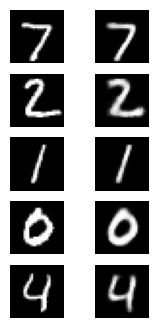

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 2, figsize=(2, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    reconstructed, codes, _ = model(digit, return_codes=True)

    axes[i][0].imshow(digit.view(28, 28).cpu().detach().numpy(), cmap="gray")
    axes[i][1].imshow(reconstructed.view(28, 28).cpu().detach().numpy(), cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")

plt.show()

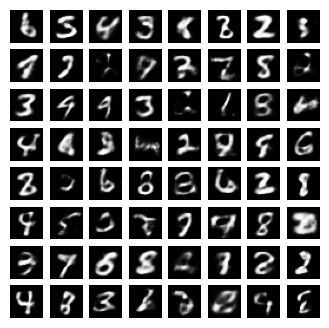

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(8, 8, figsize=(4, 4))
random_codes = torch.randint(0, 8, (8, 8, 16)).to("cuda")

for i in range(8):
    for j in range(8):
        reconstructed = model.decode_from_codes(random_codes[i, j].view(1, 16))

        axes[i, j].imshow(reconstructed.view(28, 28).cpu().detach().numpy(), cmap="gray")
        axes[i, j].axis("off")

plt.show()